In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/reviews/TrainingDataPositive.txt
/kaggle/input/reviews/TestReviews.csv
/kaggle/input/reviews/TrainingDataNegative.txt
/kaggle/input/fasttext-model/wiki-news-300d-1M.vec


In [2]:
!head  '/kaggle/input/reviews/TestReviews.csv'


"Fantastic spot for an even or a quite cocktail.  They were swell to host the Yelp crew with a great drink menu and super attentive staff.I'd certainly recommend anything with the purred fruit in it (apple, any of them really)!

"Love, love, love the calamari. It's so good and spicy. There is an endless list of martinis and one is better than the next. There is a first and second floor, if you prefer more of a bar or lounge atmosphere. It's not a place I like for dinner, but for drinks and apps it's wonderful.

"Love this place. Stiff martinis and cocktails, cheap drinks, good service, nice atmosphere to chill in the upstairs lounge and hang up with your friends. Classy crowd and much more mature, older, and professional crowd. There aren't any of those college frat boys or belligerent drunks there, which is so great. Very nice place to wind down after a long day.

"It's everything a great cocktail bar should be.  Great location, ambiance, cocktails and chill environment.**Disclaimer:

In [3]:
import pandas as pd
from gensim.models import FastText
from gensim.utils import simple_preprocess
# Path to your text file

file_path= '/kaggle/input/reviews/TrainingDataNegative.txt'

# Read the text file into a list of strings (each line as a separate string)
with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()
# Tokenize the text into words
tokenized_data = [simple_preprocess(sentence) for sentence in text_data.split('\n') if sentence]
# Train a FastText model on the tokenized data
fasttext_model = FastText(sentences=tokenized_data, vector_size=100, window=5, min_count=1, sg=1, epochs=10)
# Function to find and print 10 most similar words to a given word
def print_similar_words(word, model, top_n=10):
    if word in model.wv:
        similar_words = model.wv.most_similar(word, topn=top_n)
        print(f"Top {top_n} words similar to '{word}':")
        for similar_word, similarity in similar_words:
            print(f"{similar_word}: {similarity:.4f}")
    else:
        print(f"'{word}' is not in the vocabulary of the FastText model.")
# Example usage: Finding similar words to 'example_word' (replace with your word)
example_word = 'product'  # Replace with the word you want to find similar words for
print_similar_words(example_word, fasttext_model)

Top 10 words similar to 'product':
products: 0.9578
produce: 0.9526
production: 0.9306
produces: 0.9082
reproduction: 0.8978
projects: 0.8946
duct: 0.8856
pros: 0.8846
promos: 0.8821
prosper: 0.8790


Logistic Regression:
Accuracy: 0.912057394121731
Precision: 0.9027477616548317
Recall: 0.9782535965205754
Random Forest:
Accuracy: 0.905114556815552
Precision: 0.8906392002423508
Recall: 0.9836065573770492


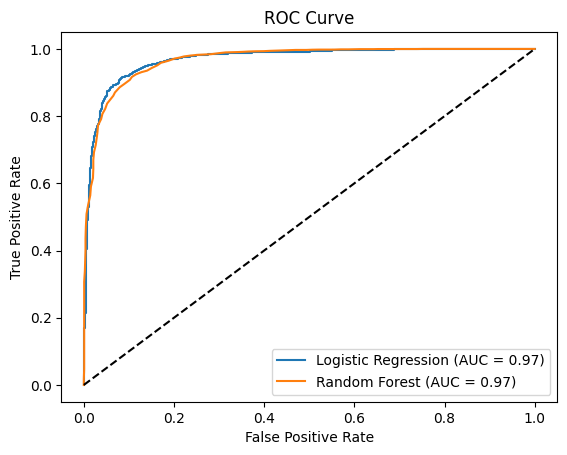

In [4]:

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
import re
import gensim

# Function to tokenize text using regular expressions
def simple_tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

# Step 1: Load the datasets
negative_reviews = pd.read_csv('/kaggle/input/reviews/TrainingDataNegative.txt', sep='\t', names=['review'], header=None)
positive_reviews = pd.read_csv('/kaggle/input/reviews/TrainingDataPositive.txt', sep='\t', names=['review'], header=None)
test_reviews = pd.read_csv('/kaggle/input/reviews/TestReviews.csv')

# Add sentiment labels
negative_reviews['sentiment'] = 'negative'
positive_reviews['sentiment'] = 'positive'

# Combine training datasets into one DataFrame
train_data = pd.concat([negative_reviews, positive_reviews], ignore_index=True)

# Tokenize the reviews using the simple tokenizer
train_data['tokens'] = train_data['review'].apply(simple_tokenize)
test_reviews['tokens'] = test_reviews['review'].apply(simple_tokenize)

# Step 2: Load FastText embeddings from a local file
# Ensure you upload the FastText model to your environment and specify the correct file path
# Download FastText model from: https://fasttext.cc/docs/en/crawl-vectors.html (use 'wiki-news-300d-1M.vec.zip')

# Unzip the file and provide the path to the unzipped `.vec` file
# Example path for Kaggle: '/kaggle/input/fasttext-embeddings/wiki-news-300d-1M.vec'
fasttext_model_path = '/kaggle/input/fasttext-model/wiki-news-300d-1M.vec'  # Replace this path with your actual path

# Load the FastText model using gensim's KeyedVectors
fasttext_model = gensim.models.KeyedVectors.load_word2vec_format(fasttext_model_path, binary=False)

# Step 3: Function to compute the average embedding for each review
def get_avg_embedding(tokens, model):
    embeddings = [model[word] for word in tokens if word in model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

# Apply the function to compute embeddings for each review
train_data['embedding'] = train_data['tokens'].apply(lambda tokens: get_avg_embedding(tokens, fasttext_model))
test_reviews['embedding'] = test_reviews['tokens'].apply(lambda tokens: get_avg_embedding(tokens, fasttext_model))

# Step 4: Label the vectors according to sentiment
train_data['label'] = train_data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
test_reviews['label'] = test_reviews['class']  # Assuming 'class' is already 1 for positive and 0 for negative

# Prepare data for model training
X_train = np.vstack(train_data['embedding'].values)
y_train = train_data['label'].values
X_test = np.vstack(test_reviews['embedding'].values)
y_test = test_reviews['label'].values

# Step 5: Train and evaluate Logistic Regression and Random Forest models
# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Metrics for Logistic Regression
print('Logistic Regression:')
print('Accuracy:', accuracy_score(y_test, y_pred_lr))
print('Precision:', precision_score(y_test, y_pred_lr))
print('Recall:', recall_score(y_test, y_pred_lr))

# Metrics for Random Forest
print('Random Forest:')
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Precision:', precision_score(y_test, y_pred_rf))
print('Recall:', recall_score(y_test, y_pred_rf))

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

# Calculate the area under the curve (AUC)
auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = %0.2f)' % auc_lr)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % auc_rf)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [5]:
!pip install gensim matplotlib scikit-learn


In [6]:
import pandas as pd
from gensim.models import FastText
from gensim.utils import simple_preprocess
import numpy as np

# Path to your text file
file_path = '/kaggle/input/reviews/TrainingDataNegative.txt'

# Read the text file into a list of strings (each line as a separate string)
with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

# Tokenize the text into words
tokenized_data = simple_preprocess(text_data)

# Train a FastText model on the tokenized data
fasttext_model = FastText(sentences=[tokenized_data], vector_size=100, window=5, min_count=1, sg=1, epochs=10)

# Example usage: Getting word vectors for specific words
word_service = fasttext_model.wv['service']
print(f"Vector for 'service': {word_service}")

# Calculate the average word vector for the entire text data
def average_word_vector(words, model, vector_size):
    valid_words = [word for word in words if word in model.wv]
    if not valid_words:
        return np.zeros(vector_size)
    return np.mean([model.wv[word] for word in valid_words], axis=0)

# Calculate average vectors for the entire text data
text_vector = average_word_vector(tokenized_data, fasttext_model, 100)
print(f"Vector for the entire text data: {text_vector}")


Vector for 'service': [ 0.33737868  0.3153288  -0.14034382 -0.0133243   0.5591607   0.07696193
 -0.0316358   0.8313843   0.0934861  -0.03641368  0.09375511 -0.38812935
  0.49512872  1.2597662   0.0057736  -0.6957582  -0.07218046 -0.30187973
 -0.10539797 -0.60064214 -0.57658845 -0.05978611 -0.09615005 -0.29102334
 -0.13211478 -0.6339239  -0.51300734 -0.11778177 -0.11081693  0.19359806
 -0.49793077 -0.33356547  0.41332382 -0.15526491  0.5037464   0.32705018
 -0.20312475  0.2366389  -0.07579728 -0.31689367 -0.01641513 -0.64498234
 -0.11173945 -0.40214807 -0.34968272  0.05636526 -0.2549676   0.05495897
  0.20968851 -0.2097151   0.47861862 -0.38517773  0.25212947 -0.41367054
  0.244593   -0.04986498 -0.2563833   0.03099154  0.254167    0.18421692
  0.01916844 -0.5937602   0.45208156  0.27781355 -0.18969938  0.9037859
  0.4369333   0.22953933 -0.08143844  0.27504197  0.08619455  0.5842361
  0.43651026 -0.49804145  0.02492757 -0.07914338  0.61357856 -0.24626188
 -0.37056574 -0.04881837 -0.544

from gensim.models import FastText

custom_fasttext_model = FastText.load("custom_fasttext_model.model")


[('products', 0.9330675601959229), ('productive', 0.8978246450424194), ('production', 0.8878964185714722), ('productssugar', 0.8868740200996399), ('productivity', 0.8810027837753296), ('produce', 0.8629860281944275), ('produces', 0.8627926707267761), ('producing', 0.861389696598053), ('productions', 0.8488863110542297), ('producers', 0.8416194915771484), ('prodigal', 0.8186325430870056), ('produced', 0.7963311076164246), ('prospect', 0.7923737168312073), ('procedures', 0.7914303541183472), ('merchandise', 0.7785483002662659), ('conducts', 0.772990345954895), ('proof', 0.766252338886261), ('fraternity', 0.7643038630485535), ('merchandiseold', 0.7641234397888184), ('prohibition', 0.7620325684547424)]


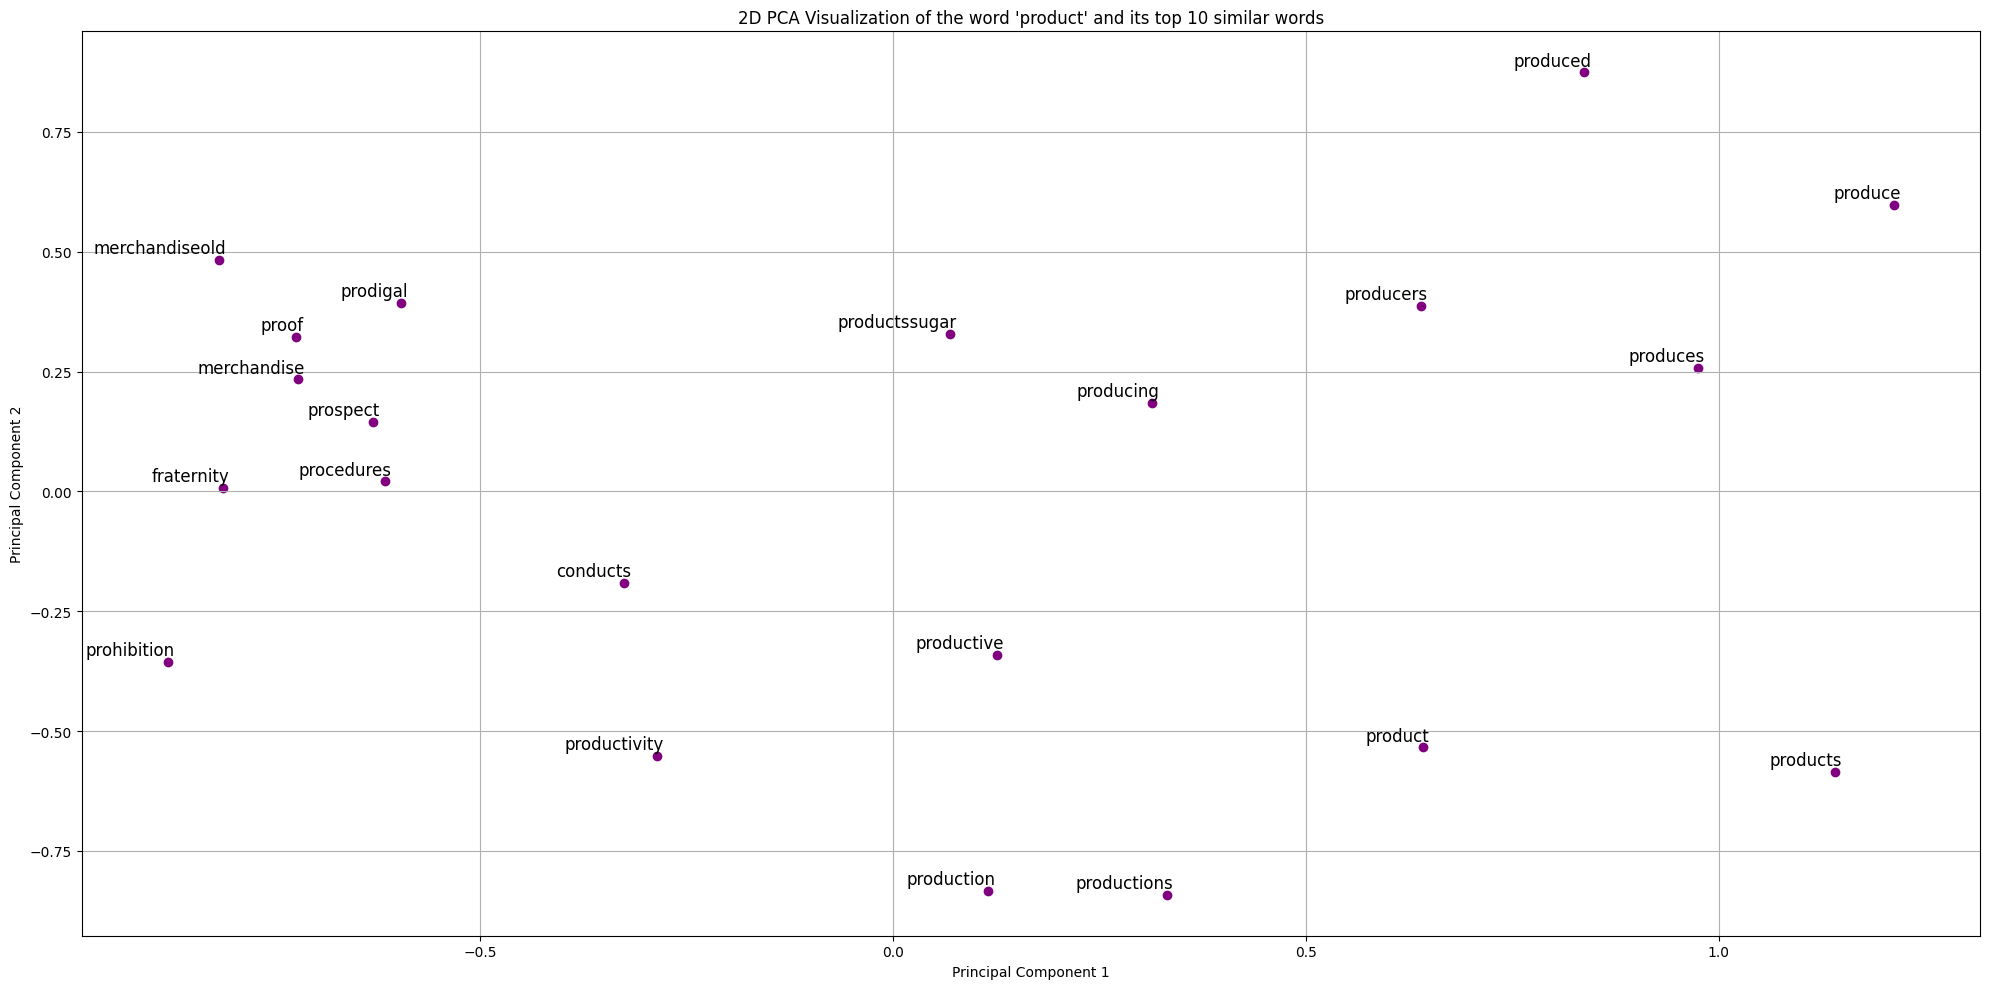

In [7]:

import matplotlib.pyplot as plt
from gensim.models import FastText
from sklearn.decomposition import PCA
from gensim.utils import simple_preprocess

# Path to your text file
file_path = '/kaggle/input/reviews/TrainingDataPositive.txt'

# Read the text file into a list of strings (each line as a separate string)
with open(file_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

# Tokenize the text into sentences and then into words
tokenized_data = [simple_preprocess(sentence) for sentence in text_data.split('\n') if sentence]

# Train FastText model on your data
custom_fasttext_model = FastText(
    sentences=tokenized_data, 
    vector_size=100, 
    window=5, 
    min_count=1, 
    sg=1, 
    epochs=10
)

# Example word to find similar words for
example_word = 'product'  # Replace with your word of interest

# Check if the example word is in the vocabulary
if example_word in custom_fasttext_model.wv:
    # Get the top 10 most similar words
    similar_words = custom_fasttext_model.wv.most_similar(example_word, topn=20)
    print(similar_words)
    words = [example_word] + [word for word, _ in similar_words]
    vectors = [custom_fasttext_model.wv[word] for word in words]

    # Reduce dimensionality of word vectors to 2D using PCA
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(vectors)

    # Plot the words and their vectors
    plt.figure(figsize=(20, 10))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c='purple')

    for i, word in enumerate(words):
        plt.annotate(word, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom', fontsize=12)

    plt.title(f"2D PCA Visualization of the word '{example_word}' and its top 10 similar words")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print(f"'{example_word}' is not in the vocabulary of the FastText model.")
